## Тестовое задание СовкомБанк
По датасету из вложения построить наилучший бинарный классификатор, целевой столбец – mark. Оформить в виде jupyter notebook либо .py скрипта (тогда вывод должен быть описан в отдельном файле txt/excel/etc.).
По стеку ограничений нет.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

pd.set_option('future.no_silent_downcasting', True)

In [2]:
df = pd.read_csv('test_set.csv', sep=';')

### 1. Подготовка к анализу

In [3]:
df.head()

,Ft 0,Ft 1,Ft 2,Ft 3,Ft 4,Ft 5,Ft 6,Ft 7,Ft 8,Ft 9,Ft 10,Ft 11,Ft 12,Ft 13,Ft14,Ft15,Ft16,Ft17,mark
0,"1,620967441","1,056247539","0,114202756","6,175593118","5,625788653","0,581534732","7,36008491",68,male,very_low,535.0,True,5,5,0,NaN,car,0,0
1,"1,274493754","0,814288286","0,727209536","3,606358987","1,493780041","7,810749616","20,31433496",24,female,high,846.0,False,3,1,1,quite rich,car,1,0
2,"0,569931174","1,60716999","0,479580989","3,521473852","1,663726488","2,297903397","12,83928197",67,male,high,782.0,False,0,0,0,moderate,furniture/equipment,1,0
3,"0,547560436","1,724393379","0,682358389","1,809471912","10,14972052","2,999318905","49,10852952",42,male,medium,132.0,False,3,3,0,quite rich,car,0,0
4,"1,798883775","1,748245353","1,045645858","1,560427303","1,269053256","1,4039525","5,270950817",84,male,very_low,708.0,False,0,0,0,NaN,radio/TV,1,0


In [4]:
# нормальные названия для фичей
feats = [f'ft_{i}' for i in range(18)] + ['mark']
df.columns = feats

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ft_0    5000 non-null   object 
 1   ft_1    5000 non-null   object 
 2   ft_2    5000 non-null   object 
 3   ft_3    5000 non-null   object 
 4   ft_4    5000 non-null   object 
 5   ft_5    5000 non-null   object 
 6   ft_6    5000 non-null   object 
 7   ft_7    5000 non-null   int64  
 8   ft_8    5000 non-null   object 
 9   ft_9    5000 non-null   object 
 10  ft_10   4936 non-null   float64
 11  ft_11   4950 non-null   object 
 12  ft_12   5000 non-null   int64  
 13  ft_13   5000 non-null   int64  
 14  ft_14   5000 non-null   int64  
 15  ft_15   4183 non-null   object 
 16  ft_16   5000 non-null   object 
 17  ft_17   5000 non-null   int64  
 18  mark    5000 non-null   int64  
dtypes: float64(1), int64(6), object(12)
memory usage: 742.3+ KB


In [6]:
# первые колонки - float числа 
cols_to_replace = df.columns[range(7)]
df[cols_to_replace] = df[cols_to_replace].apply(lambda x: x.str.replace(",", ".").astype(float)) 

### 2. Разведочный анализ

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ft_0,5000.0,1.157080,0.702209,0.066066,0.660346,1.000119,1.471052,5.942049
ft_1,5000.0,1.060064,0.420866,0.177825,0.765661,0.992588,1.292738,3.331410
ft_2,5000.0,0.839764,0.508024,0.017505,0.498008,0.731577,1.052030,6.169126
ft_3,5000.0,1.439738,1.402939,0.001728,0.484095,1.032661,1.921633,19.940927
ft_4,5000.0,2.081017,3.022327,0.000007,0.407973,1.253750,2.681746,86.940693
ft_5,5000.0,1.665331,1.716978,0.002628,0.468759,1.202163,2.291755,23.327828
ft_6,5000.0,14.005111,14.416559,0.190074,4.817639,9.584938,17.884976,157.312632
ft_7,5000.0,51.103600,19.526688,18.000000,34.000000,51.000000,68.000000,85.000000
ft_10,4936.0,552.702998,249.698601,99.000000,305.000000,560.000000,784.000000,981.000000
ft_12,5000.0,2.712000,20.152784,-1000.000000,1.000000,4.000000,5.000000,5.000000


In [8]:
# количество пропусков
omissions = pd.DataFrame({
    'NaN counts': df.isna().sum(),
    'NaN counts, %': (df.isna().sum() / df.count()).mul(100).round(2),
    'dtype': df.dtypes,
    'unique count': df.nunique()
})
omissions.T

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
NaN counts,0,0,0,0,0,0,0,0,0,0,64,50,0,0,0,817,0,0,0
"NaN counts, %",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,1.01,0.0,0.0,0.0,19.53,0.0,0.0,0.0
dtype,float64,float64,float64,float64,float64,float64,float64,int64,object,object,float64,object,int64,int64,int64,object,object,int64,int64
unique count,5000,5000,5000,5000,5000,5000,5000,68,2,4,545,2,7,7,2,4,8,2,2


In [9]:
omissions[omissions['NaN counts'] > 0]

,NaN counts,"NaN counts, %",dtype,unique count
ft_10,64,1.30,float64,545
ft_11,50,1.01,object,2
ft_15,817,19.53,object,4


`ft_10` будем заполнять медианой, `ft_15`, `ft_11` - модой:

In [10]:
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

df[['ft_10']] = median_imputer.fit_transform(df[['ft_10']])
df[['ft_11', 'ft_15']] = mode_imputer.fit_transform(df[['ft_11', 'ft_15']])
df['ft_11'] = df['ft_11'].astype(int)

In [11]:
df.head()

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
0,1.620967,1.056248,0.114203,6.175593,5.625789,0.581535,7.360085,68,male,very_low,535.0,1,5,5,0,little,car,0,0
1,1.274494,0.814288,0.727210,3.606359,1.493780,7.810750,20.314335,24,female,high,846.0,0,3,1,1,quite rich,car,1,0
2,0.569931,1.607170,0.479581,3.521474,1.663726,2.297903,12.839282,67,male,high,782.0,0,0,0,0,moderate,furniture/equipment,1,0
3,0.547560,1.724393,0.682358,1.809472,10.149721,2.999319,49.108530,42,male,medium,132.0,0,3,3,0,quite rich,car,0,0
4,1.798884,1.748245,1.045646,1.560427,1.269053,1.403952,5.270951,84,male,very_low,708.0,0,0,0,0,little,radio/TV,1,0


In [12]:
df.isna().any().sum() # пропусков нет 

0

#### Визуализируем распределения, оценим визуально соотношения классов, наличие выбросов и т.д.:

In [14]:
numeric_features = df.loc[:, df.nunique() >= 100].columns.tolist()
cat_features = df.loc[:, df.nunique() < 100].columns.tolist()

In [15]:
len(cat_features) + len(numeric_features) == len(df.columns) # проверка, что ничего не потеряли

True

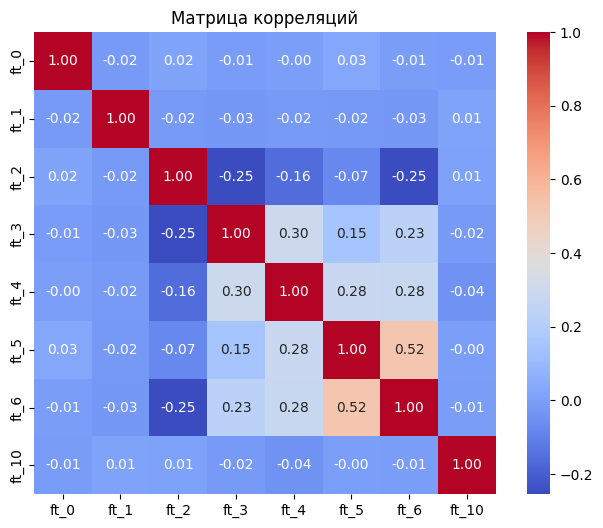

In [18]:
# посмотрим матрицу корреляций
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляций')
plt.show()

Мульколлинеарности фичей нет

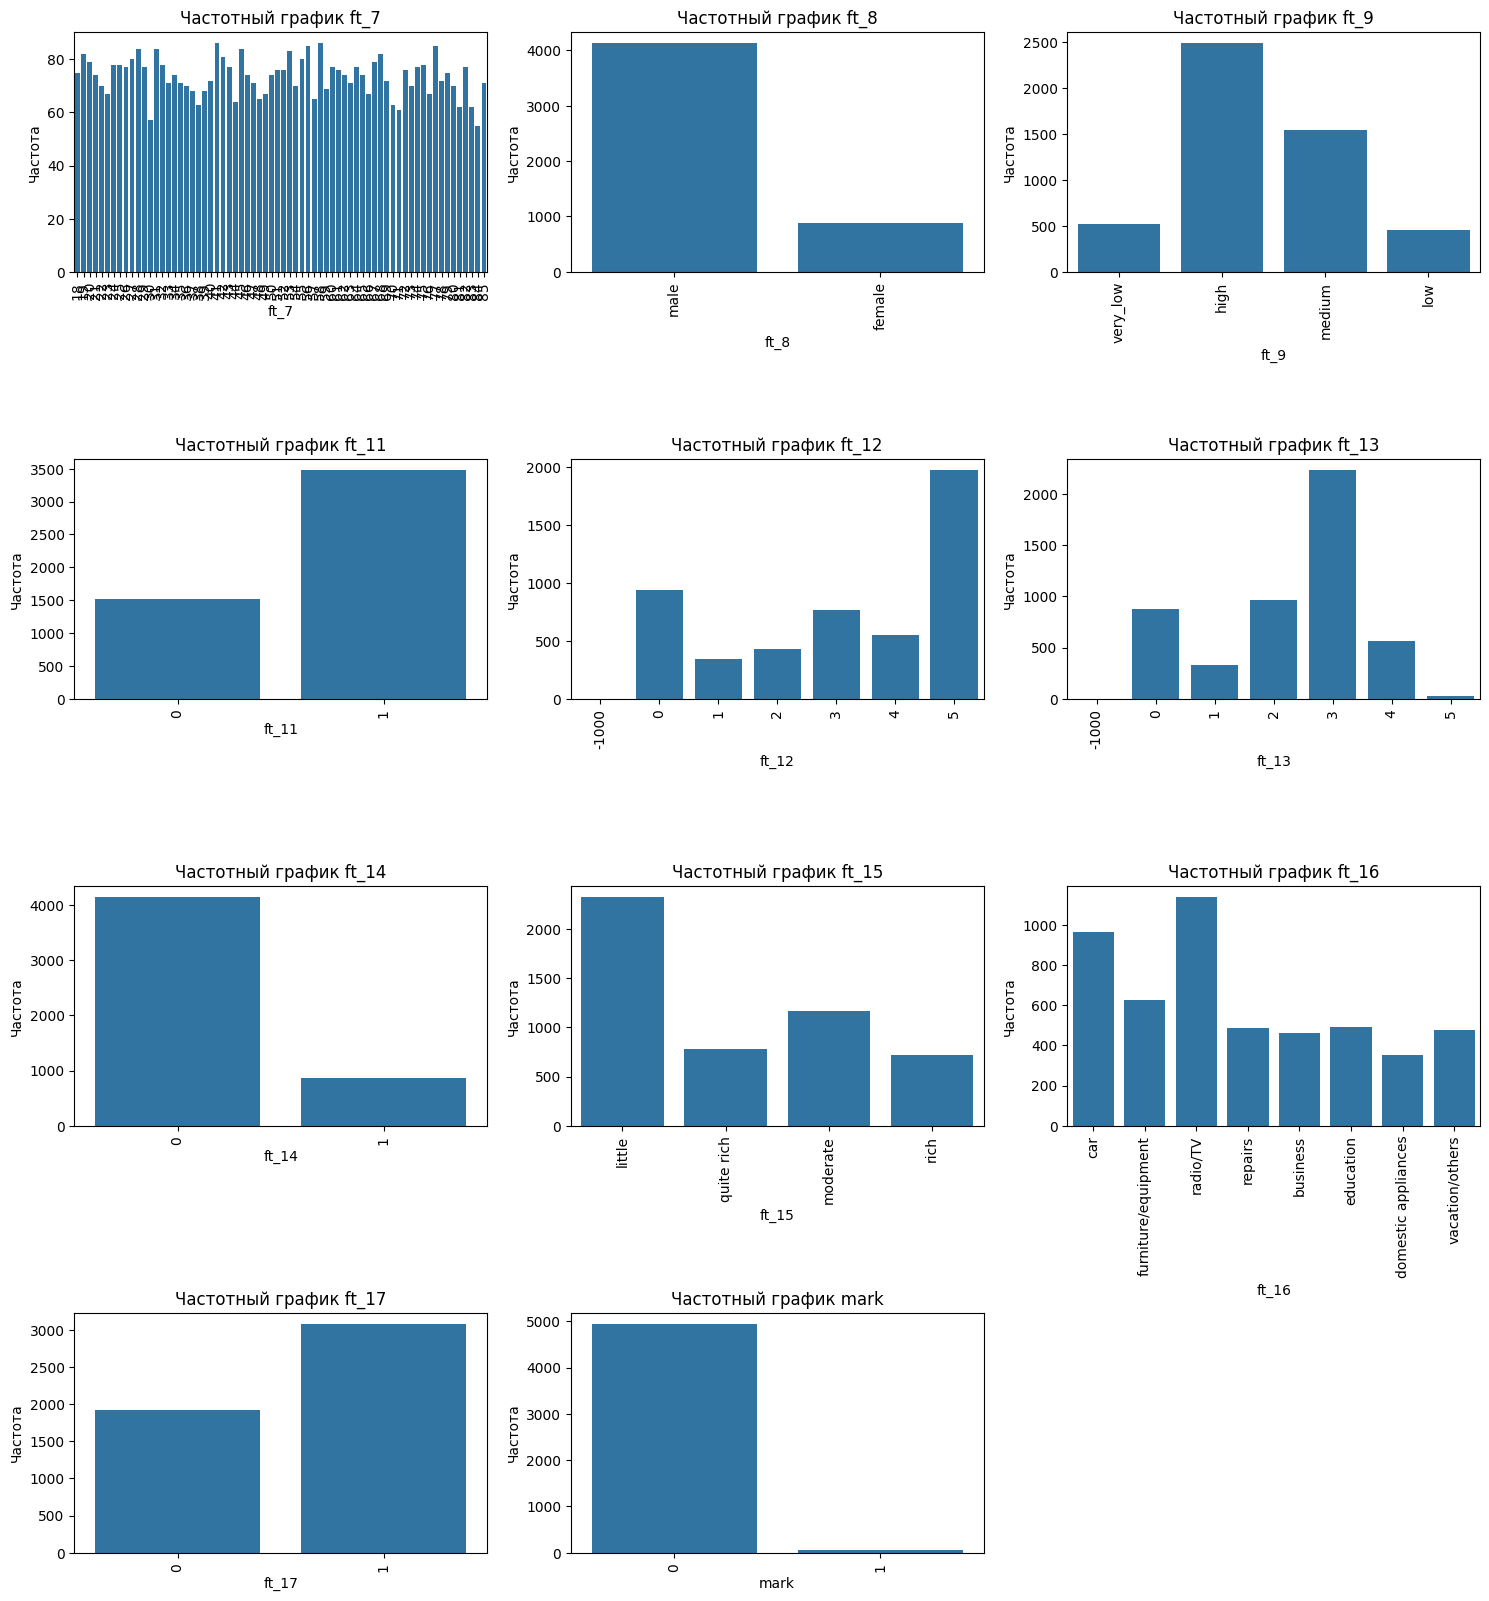

In [19]:
plt.figure(figsize=(15, 20))

for i, col in enumerate(cat_features):
    plt.subplot(5, 3, 1 + i)
    sns.countplot(x=col, data=df)
    plt.title(f'Частотный график {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [20]:
df['mark'].value_counts()

mark
0    4936
1      64
Name: count, dtype: int64

In [21]:
df['ft_12'].value_counts().to_frame().T # выброс -1000

ft_12,5,0,3,4,2,1,-1000
count,1972,935,765,549,432,345,2


In [22]:
df['ft_13'].value_counts().to_frame().T # выброс -1000

ft_13,3,2,0,4,1,5,-1000
count,2232,967,873,567,332,27,2


По графикам видно, что точно присутствуют выбросы, которые нужно будет обязательно обработать. Также имеется очень сильный дисбаланс классов целевой переменной.

In [23]:
df[df['ft_12'] == -1000]

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
489,1.442300,1.248360,1.311609,0.649413,0.582174,2.186338,11.410284,53,male,low,284.0,1,-1000,-1000,0,moderate,repairs,0,0
979,3.345153,1.154342,0.592597,0.148688,0.071530,1.474806,9.826193,47,male,high,504.0,1,-1000,-1000,0,little,radio/TV,1,0


Удивительно, но -1000-выбросы у этих фичей в одних и тех же строках. Удалим:

In [24]:
df = df[df['ft_12'] != -1000]

In [25]:
(df['ft_12'] == -1000).sum() + (df['ft_13'] == -1000).sum() # проверка

0

Теперь посмотрим на распределения числовых переменных:

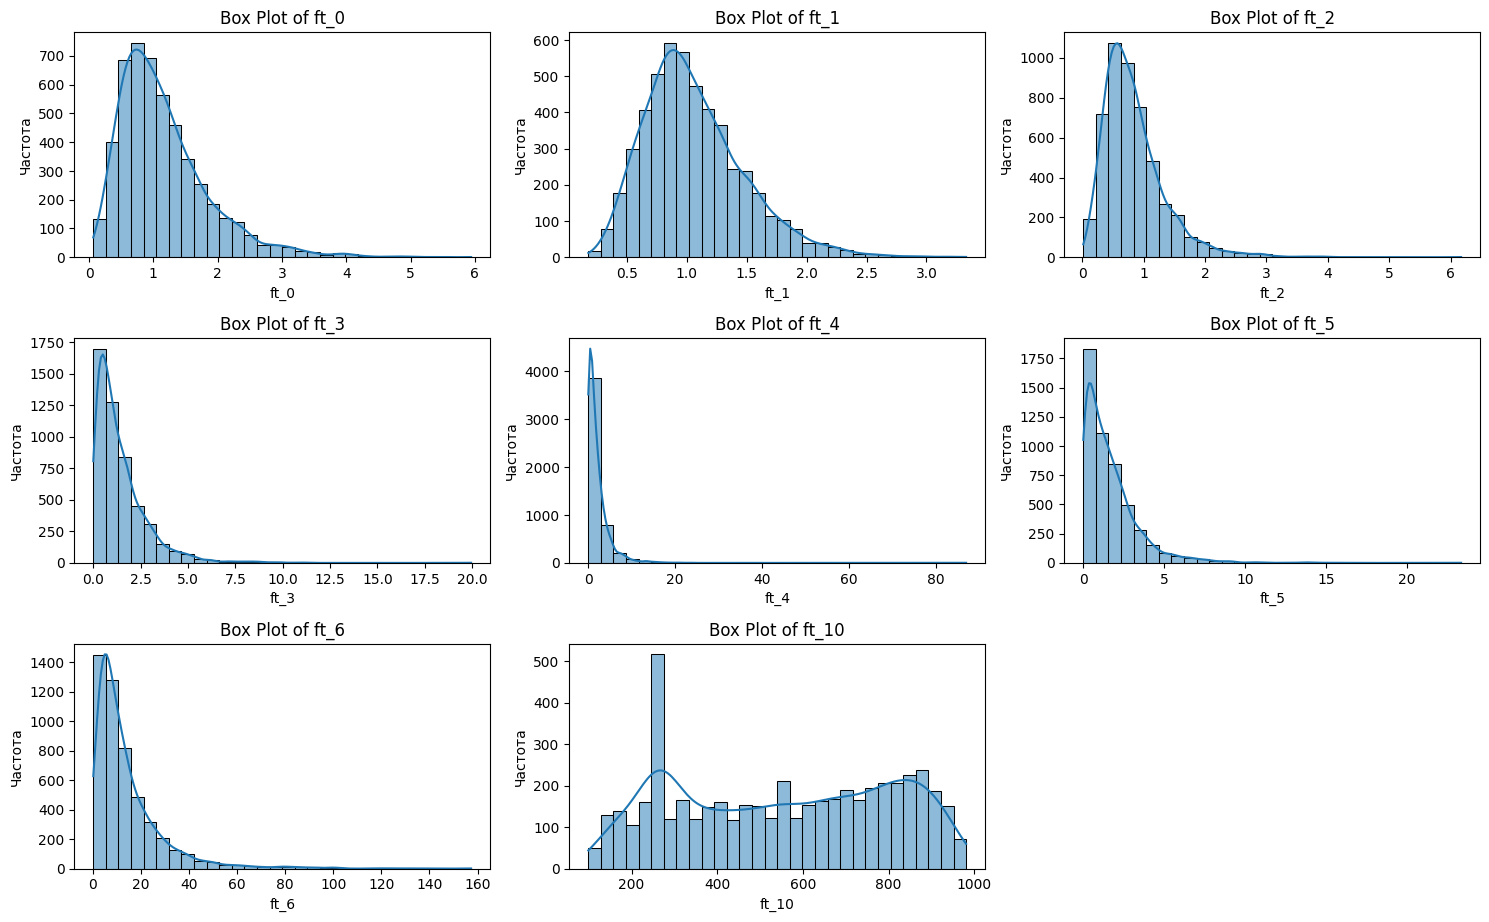

In [26]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numeric_features):
    plt.subplot(5, 3, 1 + i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Видим, в основном, скошенные вправо распределения, которые следовало бы нормализовать. Необычная форма у графика `ft_10`... Явно присутствует множество статистически значимых выбросов. Посмотрим на логарифмы распределений:

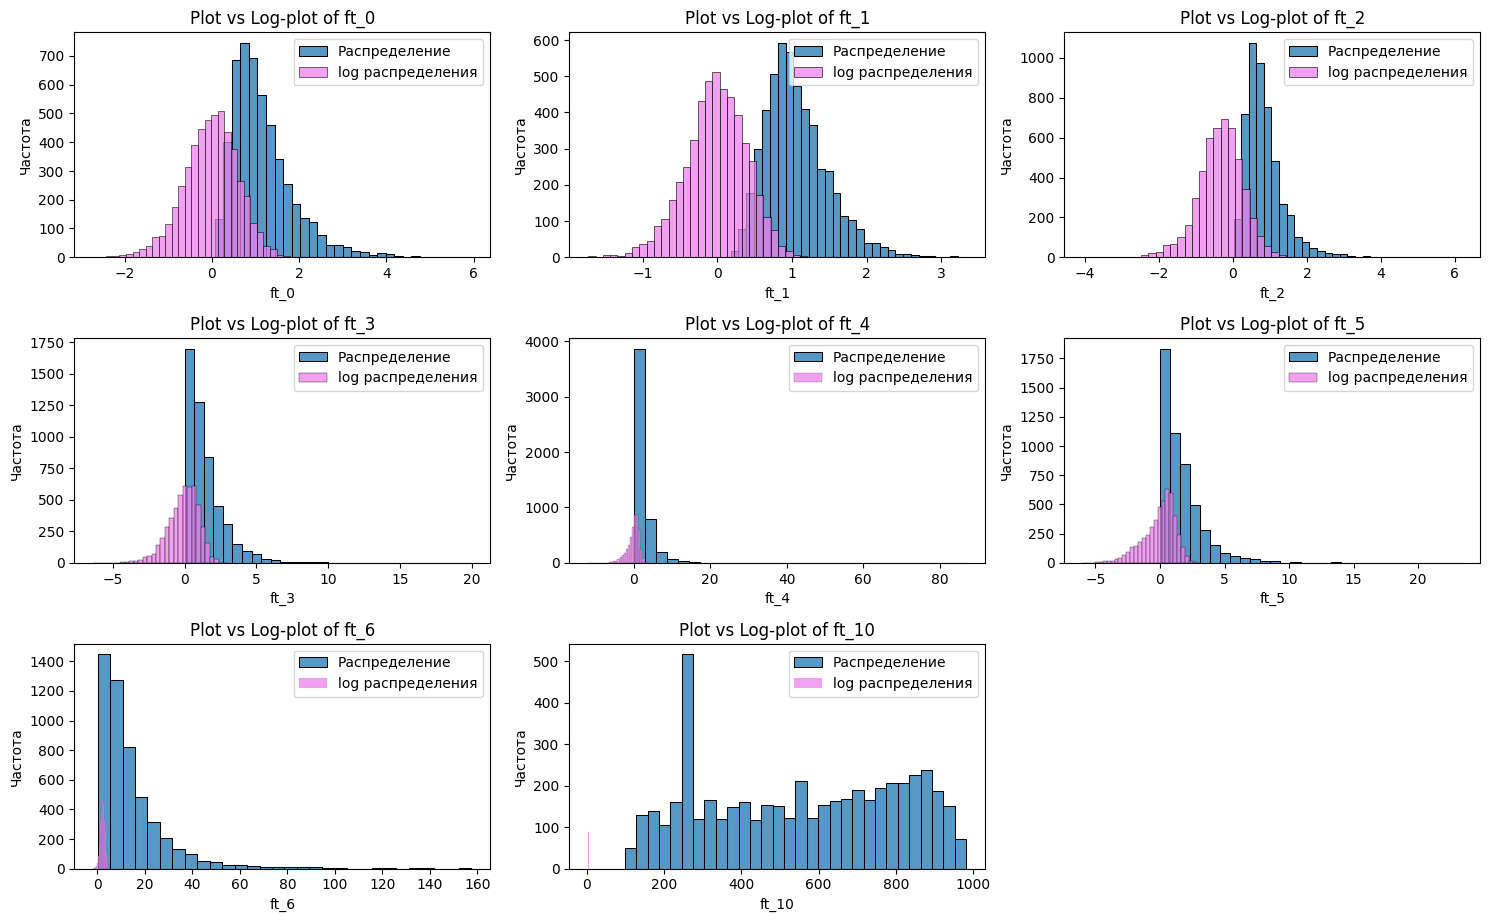

In [27]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numeric_features):
    plt.subplot(5, 3, 1 + i)
    sns.histplot(df[col], bins=30)
    plt.title(f'Plot vs Log-plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    
    plt.subplot(5, 3, 1 + i)
    sns.histplot(np.log(df[col] + 1e-7), bins=30, color='violet')
    plt.xlabel(col)
    plt.ylabel('Частота')

    plt.legend(['Распределение', 'log распределения'])

plt.tight_layout()
plt.show()

Больше похожи на нормальное распределение. Будет полезно для некоторых линейных моделей. Прологарифмируем:

In [28]:
df[numeric_features] = np.log(df[numeric_features])

Еще раз посмотрим на распределения:

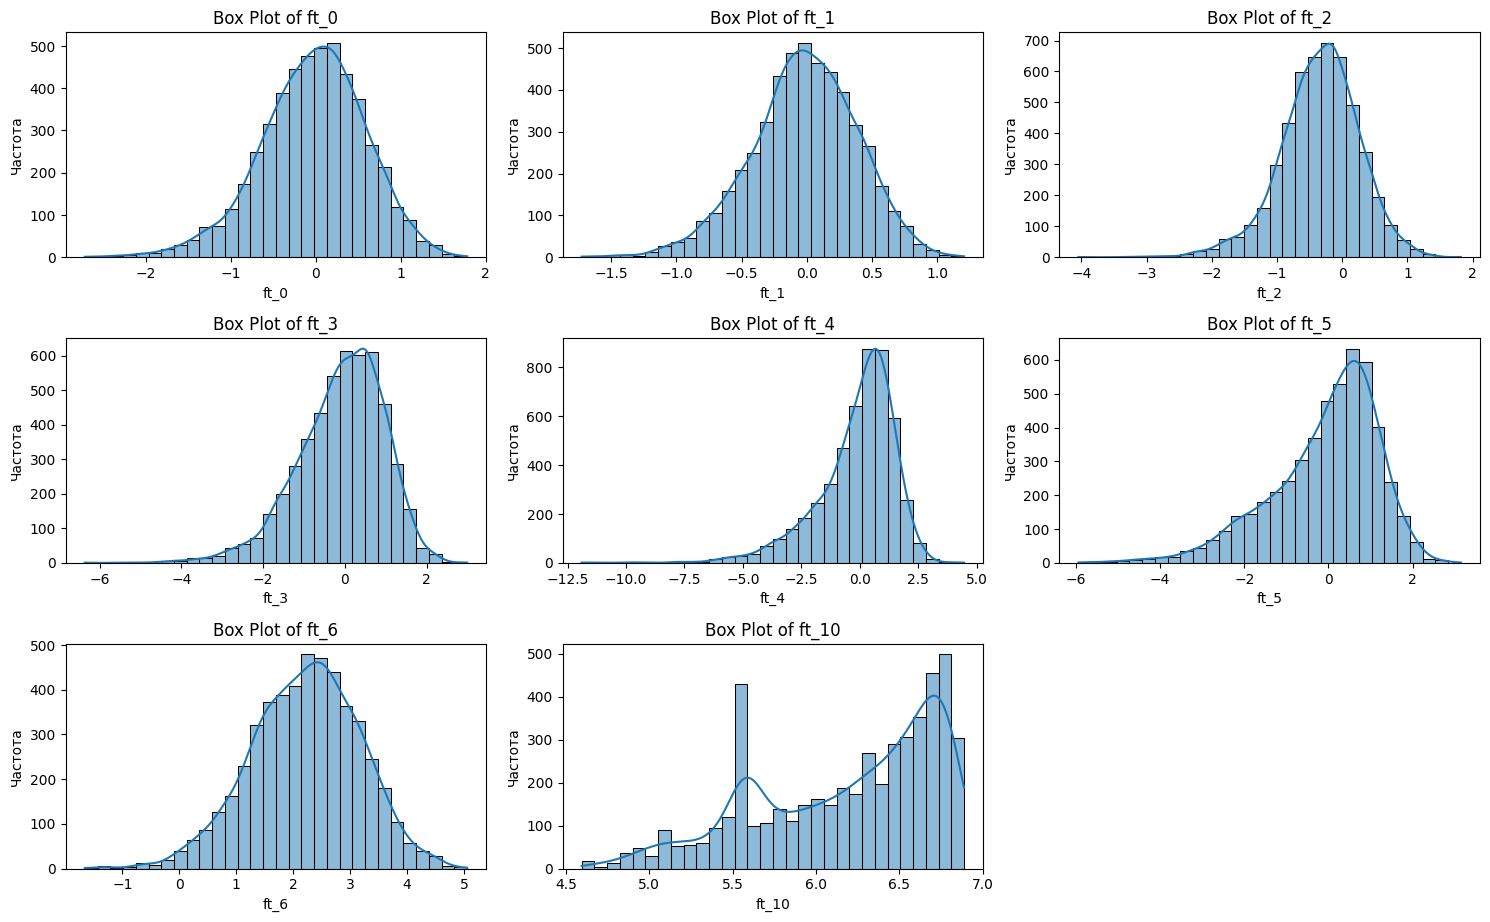

In [29]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numeric_features):
    plt.subplot(5, 3, 1 + i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Займемся выбросами. Посмотрим на ящики с усами:

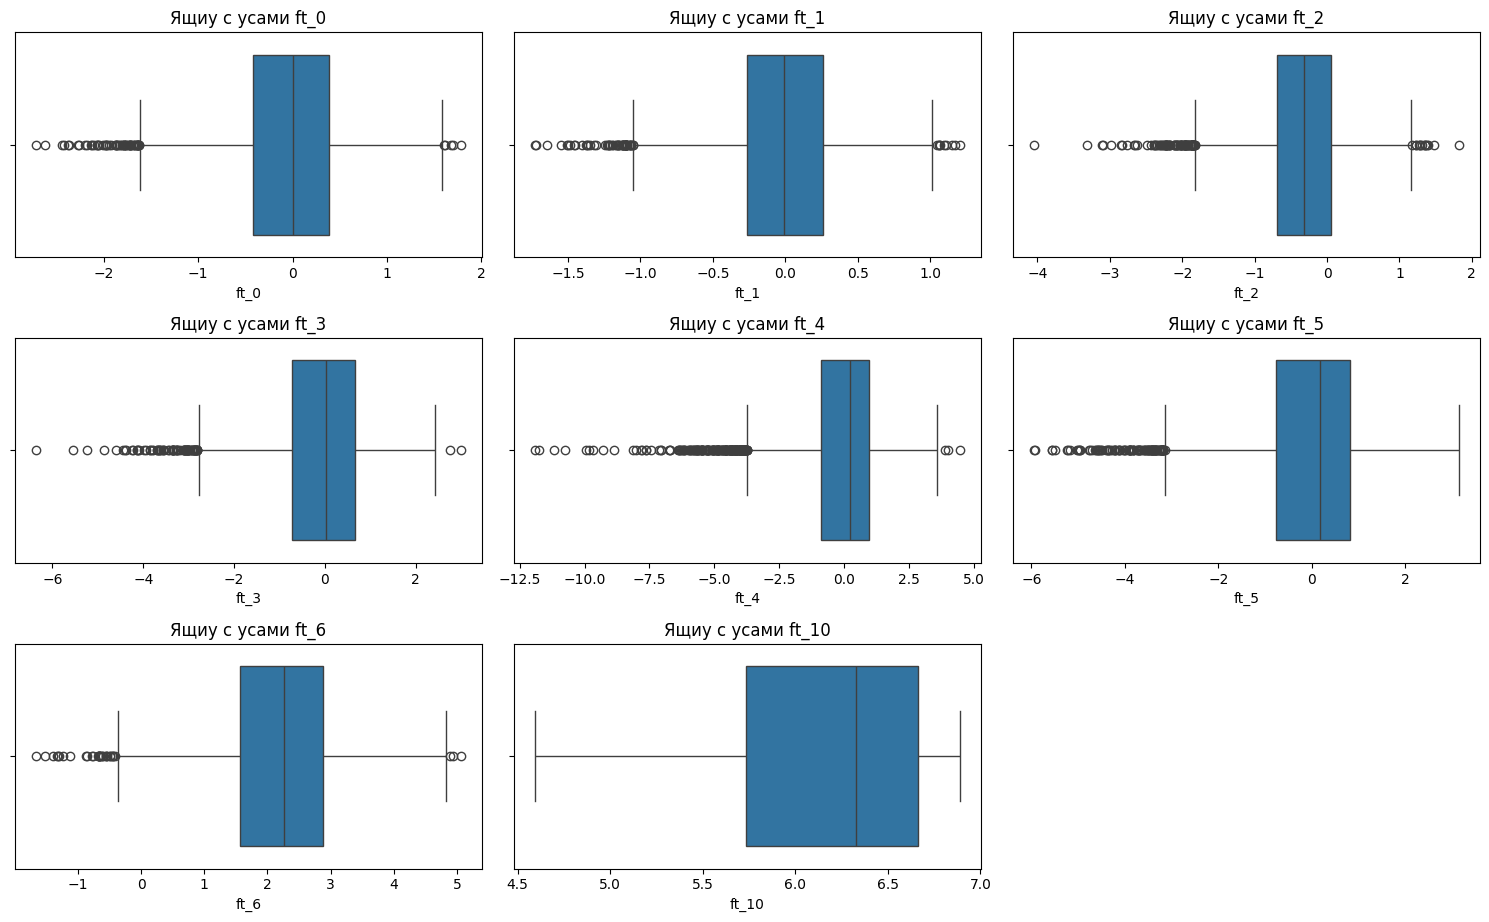

In [30]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numeric_features):
    plt.subplot(5, 3, 1 + i)
    sns.boxplot(x=col, data=df)
    plt.title(f'Ящиу с усами {col}')
    # plt.xlabel(col)
    # plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Удалим объекты, которые выходят за 1.5 IQR:

In [31]:
Q1 = df[numeric_features].quantile(0.25)
Q3 = df[numeric_features].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

mask_out = ((df[numeric_features] < lower) | (df[numeric_features] > upper)).any(axis = 1) # если в строке есть хотя бы 1 выброс
df[mask_out]['mark'].value_counts() / df['mark'].value_counts()

mark
0    0.119781
1    0.062500
Name: count, dtype: float64

В выбросах почему-то больше таргетов многочисленного класса...

In [32]:
df = df[~mask_out]

Еще раз посмотрим на распределения:

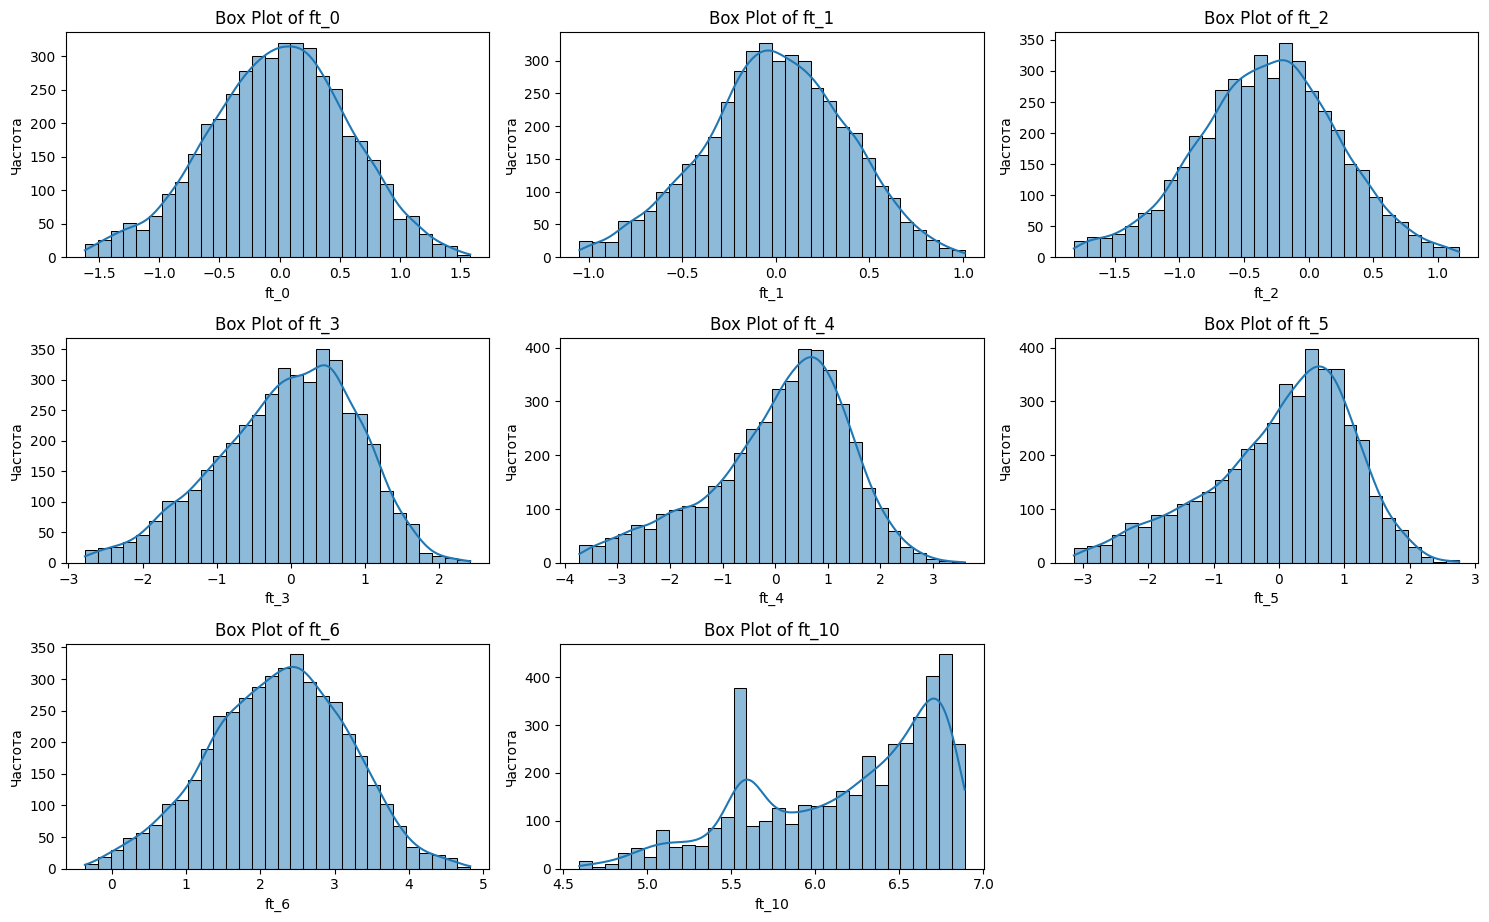

In [33]:
plt.figure(figsize=(15, 15))

for i, col in enumerate(numeric_features):
    plt.subplot(5, 3, 1 + i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Также для сходимости может быть полезно стандартизировать числовые значения:

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

Еще раз посмотрим на матрицу корреляций числовых признаков:

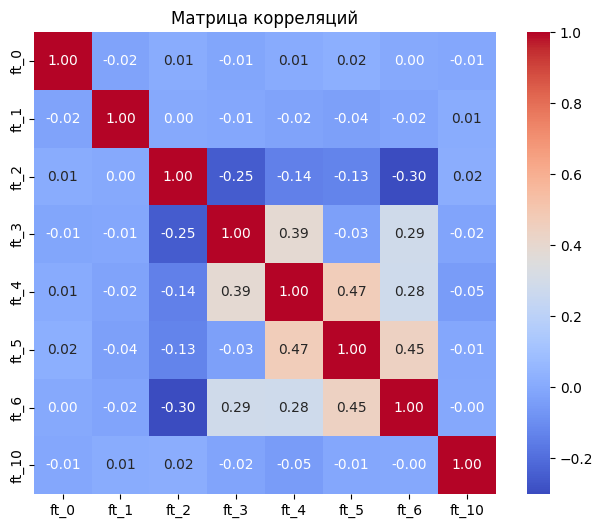

In [35]:
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(8, 6)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляций')
plt.show()

#### Кодирование категориальных переменных

Для большинства алгоритмов необходимо закодировать категориальные переменные. Также оставим копию датафрейма без кодирования для некоторых деревянных алгоритмов:

In [36]:
df_orig = df.copy()

In [37]:
cat_features_info = pd.DataFrame({
    'feature': cat_features,
    'dtype': df[cat_features].dtypes,
    'unique count': df[cat_features].nunique()
})
cat_features_info.T

,ft_7,ft_8,ft_9,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
feature,ft_7,ft_8,ft_9,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
dtype,int64,object,object,int32,int64,int64,int64,object,object,int64,int64
unique count,68,2,4,2,6,6,2,4,8,2,2


In [38]:
features_to_encode = cat_features_info[cat_features_info['dtype'] == 'object'].index.tolist()
features_to_encode

['ft_8', 'ft_9', 'ft_15', 'ft_16']

Бинарную катеогрию закодируем в {0, 1}, а остальные - с помощью target-encoding:

In [39]:
df['ft_8'] = df['ft_8'].apply(lambda x: 1 if x == 'male' else 0)

In [40]:
for cat in features_to_encode[1:]:
    mean_target_by_cat = df.groupby(cat)['mark'].mean()
    df[cat] = df[cat].map(lambda key: mean_target_by_cat[key])

In [41]:
df.head()

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
1,0.438229,-0.528629,0.001019,1.428597,0.245932,1.847863,0.842890,24,0,0.012797,1.023228,0,3,1,1,0.000000,0.008187,1,0
2,-0.951829,1.259609,-0.760256,1.403159,0.328050,0.732378,0.342892,67,1,0.012797,0.877652,0,0,0,0,0.018500,0.005405,1,0
3,-1.020992,1.444769,-0.115393,0.692062,1.706236,0.975247,1.804821,42,1,0.015396,-2.414647,0,3,3,0,0.000000,0.008187,0,0
4,1.033464,1.480899,0.665144,0.533923,0.121679,0.283171,-0.627314,84,1,0.000000,0.693683,0,0,0,0,0.016545,0.007114,1,0
5,-1.281809,0.744269,-0.451018,0.241422,0.384324,0.919064,1.590701,39,1,0.015396,1.239737,1,2,2,0,0.016545,0.016667,1,0


In [45]:
df.dtypes.to_frame().T # все фичи числовые

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
0,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int32,int64,int64,int64,float64,float64,int64,int64


In [46]:
df.describe()

,ft_0,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,mark
count,4.403000e+03,4.403000e+03,4.403000e+03,4.403000e+03,4.403000e+03,4.403000e+03,4.403000e+03,4403.000000,4403.000000,4403.000000,4.403000e+03,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000
mean,-1.291016e-17,2.662720e-17,3.873047e-17,5.648193e-18,-1.775147e-17,1.613770e-18,-1.520978e-16,50.987963,0.823984,0.013627,2.097900e-17,0.694072,3.100159,2.277765,0.173745,0.013627,0.013627,0.622757,0.013627
std,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,1.000114e+00,19.583767,0.380877,0.006122,1.000114e+00,0.460852,1.933282,1.279561,0.378933,0.006297,0.009193,0.484752,0.115950
min,-2.773296e+00,-2.746637e+00,-2.739149e+00,-2.908492e+00,-2.893654e+00,-2.886024e+00,-2.833373e+00,18.000000,0.000000,0.000000,-2.947029e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.005405,0.000000,0.000000
25%,-6.704937e-01,-6.356570e-01,-6.526452e-01,-6.584111e-01,-5.640516e-01,-5.951573e-01,-6.944287e-01,34.000000,1.000000,0.012797,-8.406468e-01,0.000000,1.000000,2.000000,0.000000,0.011164,0.007114,0.000000,0.000000
50%,2.562129e-02,7.840263e-03,2.160765e-02,1.001991e-01,1.679032e-01,1.811045e-01,4.049283e-02,51.000000,1.000000,0.012797,2.597063e-01,1.000000,4.000000,3.000000,0.000000,0.016545,0.008187,1.000000,0.000000
75%,6.862355e-01,6.973544e-01,6.756282e-01,7.238913e-01,7.067101e-01,7.283540e-01,7.112486e-01,68.000000,1.000000,0.015396,8.752838e-01,1.000000,5.000000,3.000000,0.000000,0.016545,0.016667,1.000000,0.000000
max,2.751941e+00,2.665626e+00,2.714339e+00,2.645774e+00,2.683018e+00,2.488658e+00,2.819122e+00,85.000000,1.000000,0.027363,1.297214e+00,1.000000,5.000000,5.000000,1.000000,0.018500,0.034913,1.000000,1.000000


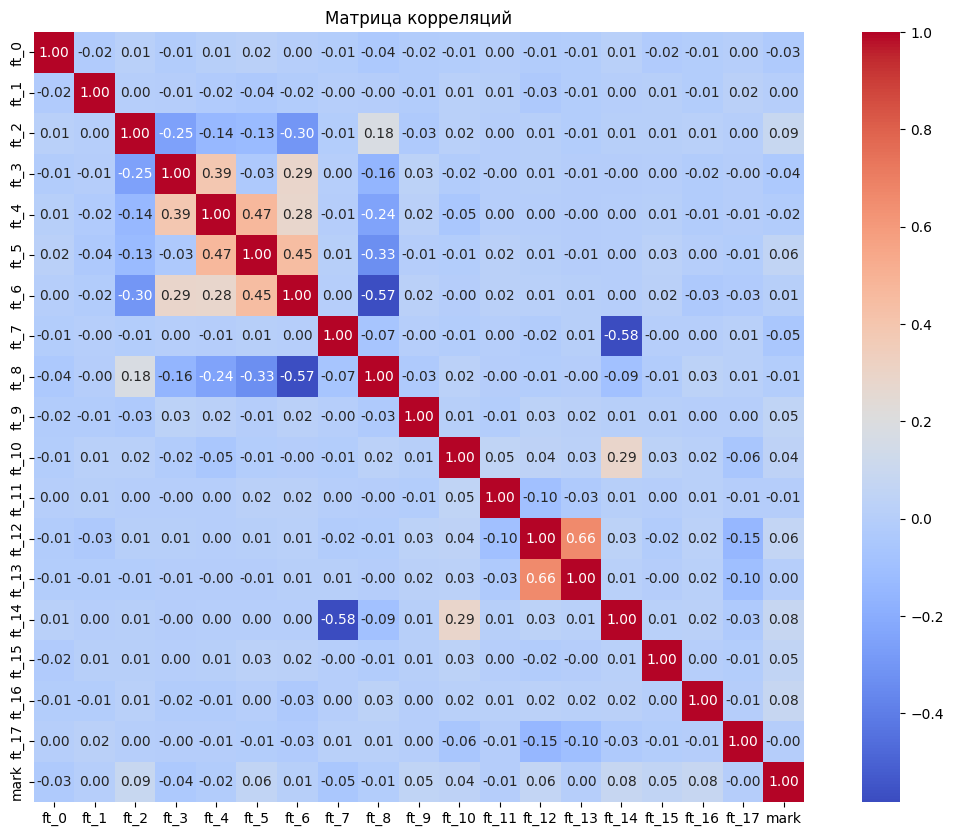

In [49]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Матрица корреляций')
plt.show()

Мулитиколлинеарности все еще нет. Можно переходить к обучению модели.

Попробуем визуализировать данные в двумерном пространстве:

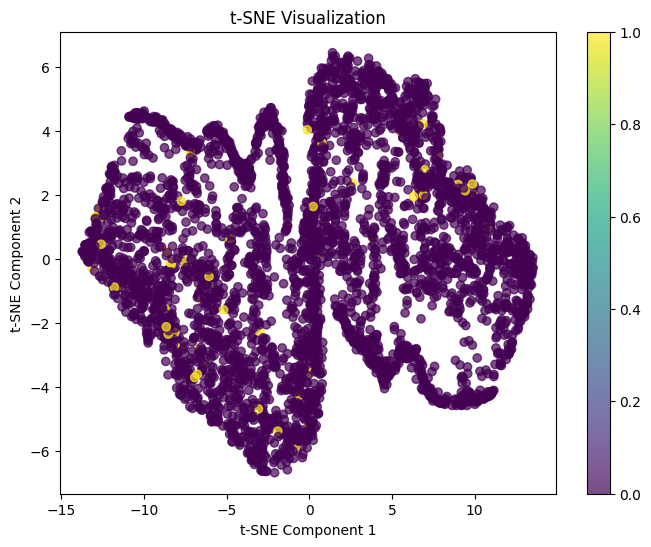

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_embedded = tsne.fit_transform(df.drop(['mark'], axis=1))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df['mark'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Нет никаких явных паттернов: целевые классы "переплетены" между собой. Похоже на плохо разделимую выборку...

#### Отбор признаков

Попробуем провести отбор значимых признаков, на которых будет обучаться модель. По корреляции мало что можно сказать о важности фичей, поэтому воспользуемся другими подходами.

Проведем на числовых переменных t-тест:

In [81]:
from scipy import stats

alpha = 0.05

group1 = df[df['mark'] == 0]
group2 = df[df['mark'] == 1]

results = {}
for feature in numeric_features:
   t_stat, p_value = stats.ttest_ind(group1[feature], group2[feature])
   results[feature] = {'t_statistic': t_stat, 'p_value': p_value, 'is_important': p_value < alpha}

ttest_df = pd.DataFrame(results)
ttest_df.T

,t_statistic,p_value,is_important
ft_0,1.969519,0.048956,True
ft_1,-0.035576,0.971622,False
ft_2,-5.732694,0.0,True
ft_3,2.805271,0.00505,True
ft_4,1.23523,0.216811,False
ft_5,-3.98259,0.000069,True
ft_6,-0.551543,0.581289,False
ft_10,-2.452073,0.014242,True


In [86]:
not_important_features_ttest = ttest_df.T.query('is_important == False').index.to_list()

In [87]:
not_important_features_ttest # возможно удалим во время обучения

['ft_1', 'ft_4', 'ft_6']

Проведем тест хи-квадрат для категориальных переменных:

In [94]:
from scipy.stats import chi2_contingency

alpha = 0.05
results = {}

for feature in cat_features[:-1]:
    contingency_table = pd.crosstab(df[feature], df['mark'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    results[feature] = {'chi2': chi2, 'p-value': p_value, 'is_important': p_value < 0.05}

chi_squared_df = pd.DataFrame(results)

In [95]:
chi_squared_df.T

,chi2,p-value,is_important
ft_7,94.179587,0.015967,True
ft_8,0.438026,0.508077,False
ft_9,12.27572,0.006496,True
ft_11,0.104205,0.74684,False
ft_12,30.200799,0.000013,True
ft_13,2.990792,0.701406,False
ft_14,26.749285,0.0,True
ft_15,12.987156,0.004664,True
ft_16,27.677612,0.000252,True
ft_17,0.0,1.0,False


In [96]:
not_important_features_chi_squared = chi_squared_df.T.query('is_important == False').index.to_list()

In [97]:
not_important_features_chi_squared # возможно удалим во время обучения

['ft_8', 'ft_11', 'ft_13', 'ft_17']

Попробуем задействовать сначала все признаки

## 3. Обучение моделей

In [98]:
X, y = df.drop(['mark'], axis=1), df['mark']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

функция для измерения качества классификатора на тесте:

In [111]:
def display_metrics(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Класс 0', 'Класс 1'], yticklabels=['Класс 0', 'Класс 1'])
    plt.ylabel('Настоящий класс')
    plt.xlabel('Предсказанный класс')
    plt.title('Матрица ошибок')
    plt.show()
    
    precision = round(precision_score(y, y_pred), 2)
    recall = round(recall_score(y, y_pred), 2)
    f1 = round(f1_score(y, y_pred, average='macro'), 2)
    roc_auc = round(roc_auc_score(y, y_pred), 2)
    print(f'Precision={precision}, recall={recall}, f1-score_macro={f1}, roc_auc={roc_auc}')

#### Логистическая регрессия

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def fit_lr(X_train, y_train):
    params = {
        'penalty': ['l1'],
        'solver': ['liblinear'],
        'C': np.linspace(0.1, 1, 10),
        'class_weight': ['balanced'],
        'max_iter': range(500, 1500, 100)
    }
    
    lr_clf = LogisticRegression()
    search = GridSearchCV(lr_clf, params, scoring='f1_macro', cv=5)
    search.fit(X_train, y_train)
    return search

In [150]:
search = fit_lr(X_train, y_train)

In [118]:
best_params = search.best_params_
best_params

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 500,
 'penalty': 'l1',
 'solver': 'liblinear'}

Подберем лучший порог отсечения классов на кросс-валидации. Возможно, порог по умолчанию 0.5 не подходит:

In [151]:
from sklearn.model_selection import StratifiedKFold

def get_best_threshold(X_train, y_train):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    thresholds = np.arange(0.0, 1.0, 0.01)
    mean_f1_scores = []
    
    for threshold in thresholds:
        f1_scores = []
        
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
            model = LogisticRegression(**best_params)
            model.fit(X_train_fold, y_train_fold)
    
            y_probs = model.predict_proba(X_test_fold)[:, 1]
            y_pred = (y_probs >= threshold).astype(int)
            
            f1 = f1_score(y_test_fold, y_pred, average='macro')
            f1_scores.append(f1)
        
        mean_f1_scores.append(np.mean(f1_scores))
    
    best_threshold = thresholds[np.argmax(mean_f1_scores)]
    best_f1_score = max(mean_f1_scores)
    print(f'Best_threshold={best_threshold}, best_f1-score_macro={best_f1_score}')
    return best_threshold

In [152]:
best_threshold = get_best_threshold(X_train, y_train)

Best_threshold=0.96, best_f1-score_macro=0.5813694159313153


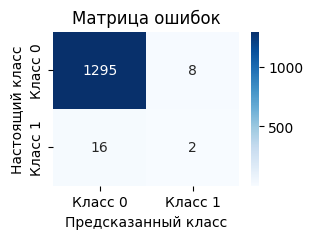

Precision=0.2, recall=0.11, f1-score_macro=0.57, roc_auc=0.55


In [153]:
bect_lr_clf = LogisticRegression(**best_params)
bect_lr_clf.fit(X_train, y_train)

proba = bect_lr_clf.predict_proba(X_test)[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Взглянем на важность фичей для предсказания модели:

In [157]:
importance = bect_lr_clf.coef_[0]
feature_names = X_train.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance}) \
    .sort_values(by='importance', ascending=False)
importance_df

,feature,importance
16,ft_16,62.744967
15,ft_15,27.723941
9,ft_9,2.763228
5,ft_5,0.788285
2,ft_2,0.772612
12,ft_12,0.557278
10,ft_10,0.354283
14,ft_14,0.305233
17,ft_17,0.074554
0,ft_0,0.058517


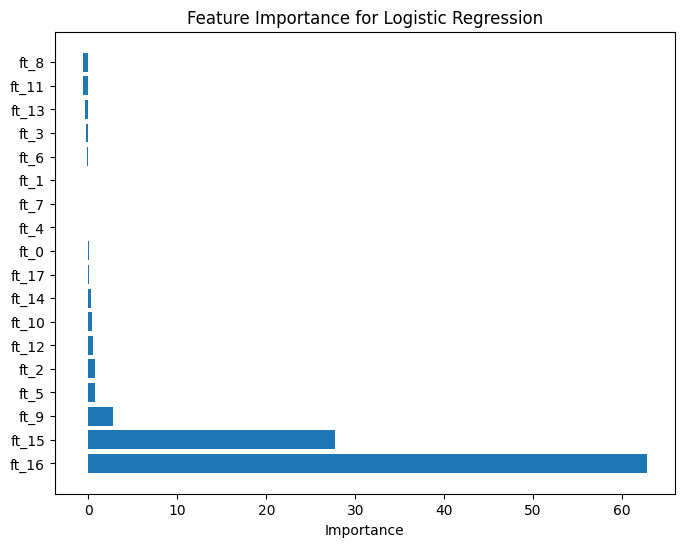

In [156]:
plt.figure(figsize=(8, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Logistic Regression')
plt.show()

Достаточно оставить всего 10 фичей, которые вносят хоть какой-то вклад в предсказание:

In [165]:
features_for_lr = importance_df.sort_values(by=['importance'], ascending=False).iloc[:10]['feature'].to_list()
features_for_lr

['ft_16',
 'ft_15',
 'ft_9',
 'ft_5',
 'ft_2',
 'ft_12',
 'ft_10',
 'ft_14',
 'ft_17',
 'ft_0']

Best_threshold=0.87, best_f1-score_macro=0.584957092848172


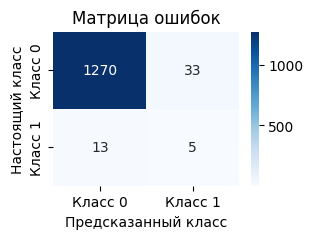

Precision=0.13, recall=0.28, f1-score_macro=0.58, roc_auc=0.63


In [166]:
search = fit_lr(X_train[features_for_lr], y_train) # без численных признаков от t-теста
best_params = search.best_params_

best_threshold = get_best_threshold(X_train[features_for_lr], y_train)

bect_lr_clf = search.best_estimator_
bect_lr_clf.fit(X_train[features_for_lr], y_train)

proba = bect_lr_clf.predict_proba(X_test[features_for_lr])[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Пока качество модели оставляет желать лучшего. Попробуем удалить признаки, которые "отсеяли" статистические тесты:

Best_threshold=0.92, best_f1-score_macro=0.5828487889707729


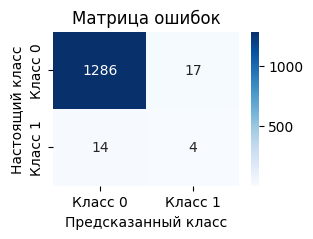

Precision=0.19, recall=0.22, f1-score_macro=0.6, roc_auc=0.6


In [127]:
search = fit_lr(X_train.drop(not_important_features_ttest, axis=1), y_train) # без численных признаков от t-теста
best_params = search.best_params_

best_threshold = get_best_threshold(X_train.drop(not_important_features_ttest, axis=1), y_train)

bect_lr_clf = search.best_estimator_
bect_lr_clf.fit(X_train.drop(not_important_features_ttest, axis=1), y_train)

proba = bect_lr_clf.predict_proba(X_test.drop(not_important_features_ttest, axis=1))[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Плохо. Попробуем удалить теперь признаки от хи-квадрат:

Best_threshold=0.89, best_f1-score_macro=0.568872801619362


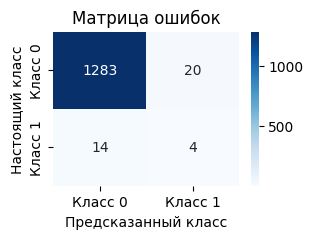

Precision=0.17, recall=0.22, f1-score_macro=0.59, roc_auc=0.6


In [128]:
search = fit_lr(X_train.drop(not_important_features_chi_squared, axis=1), y_train) # без категориальных признаков от хи-квадрат
best_params = search.best_params_

best_threshold = get_best_threshold(X_train.drop(not_important_features_chi_squared, axis=1), y_train)

bect_lr_clf = search.best_estimator_
bect_lr_clf.fit(X_train.drop(not_important_features_chi_squared, axis=1), y_train)

proba = bect_lr_clf.predict_proba(X_test.drop(not_important_features_chi_squared, axis=1))[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Попробуем удалить и те, и те признаки:

Best_threshold=0.9, best_f1-score_macro=0.5851965144737026


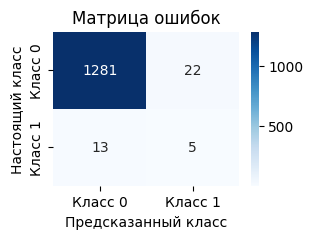

Precision=0.19, recall=0.28, f1-score_macro=0.6, roc_auc=0.63


In [129]:
del_features = not_important_features_ttest + not_important_features_chi_squared

search = fit_lr(X_train.drop(del_features, axis=1), y_train) # без категориальных признаков от хи-квадрат
best_params = search.best_params_

best_threshold = get_best_threshold(X_train.drop(del_features, axis=1), y_train)

bect_lr_clf = search.best_estimator_
bect_lr_clf.fit(X_train.drop(del_features, axis=1), y_train)

proba = bect_lr_clf.predict_proba(X_test.drop(del_features, axis=1))[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Качество стало чуть лучше, но все равно довольно низкое... Попробуем сбалансировать классы с помощью синтетических данных и использовать 10 важных признаков для модели:

In [167]:
from imblearn.over_sampling import ADASYN

def get_syn_data(X, y):
    adasyn = ADASYN(sampling_strategy='minority')
    
    X_resampled, y_resampled = adasyn.fit_resample(X, y)
    X_train_bal = pd.DataFrame(X_resampled, columns=X_train.columns)
    y_train_bal = y_resampled
    return X_train_bal, y_train_bal

Best_threshold=0.44, best_f1-score_macro=0.8088454555305477


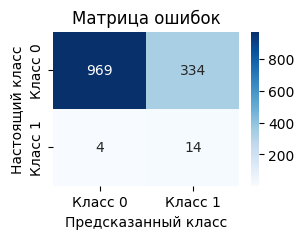

Precision=0.04, recall=0.78, f1-score_macro=0.46, roc_auc=0.76


In [168]:
X_train_bal, y_train_bal = get_syn_data(X_train, y_train)
del_features = list( set(X_train.columns) - set(features_for_lr) )

search = fit_lr(X_train_bal.drop(del_features, axis=1), y_train_bal) # без категориальных признаков от хи-квадрат
best_params = search.best_params_

best_threshold = get_best_threshold(X_train_bal.drop(del_features, axis=1), y_train_bal)

bect_lr_clf = search.best_estimator_
bect_lr_clf.fit(X_train_bal.drop(del_features, axis=1), y_train_bal)

proba = bect_lr_clf.predict_proba(X_test.drop(del_features, axis=1))[:, 1]
y_pred = (proba > best_threshold).astype(int)
display_metrics(y_test, y_pred)

Теперь потеряли в точности предсказания... Похоже данные практически невозможно идеально разделить и нужно выбирать конкретную бизнес-метрику: делать упор на точность предсказания или полноту предсказания положительного класса. Мы пока что делаем упор на качестве предсказаний обоих классов.

Проверим еще деревянные алгоритмы. Они должны показать результаты лучше.

#### Случайный лес

In [169]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def fit_rf(X_train, y_train):
    rf_params = {
        'n_estimators': range(100, 1000, 100),
        'max_depth': range(1, 30, 1),
        'min_samples_split': range(10, 50, 5),
        'min_samples_leaf': range(5, 50, 5),
        'class_weight': ['balanced', {0: 1, 1: 50}, {0: 1, 1: 100}, {0: 1, 1: 150}, {0: 1, 1: 200}],
    }

    rf_clf = RandomForestClassifier(n_jobs=-1)
    search = RandomizedSearchCV(rf_clf, rf_params, scoring='f1_macro', cv=5)
    search.fit(X_train, y_train)

    return search

In [170]:
best_rf_clf = fit_rf(X_train, y_train).best_estimator_

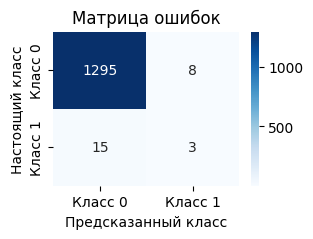

Precision=0.27, recall=0.17, f1-score_macro=0.6, roc_auc=0.58


In [171]:
y_pred = best_rf_clf.predict(X_test)
display_metrics(y_test, y_pred)

Посмотрим, какие признаки лес посчитал важными:

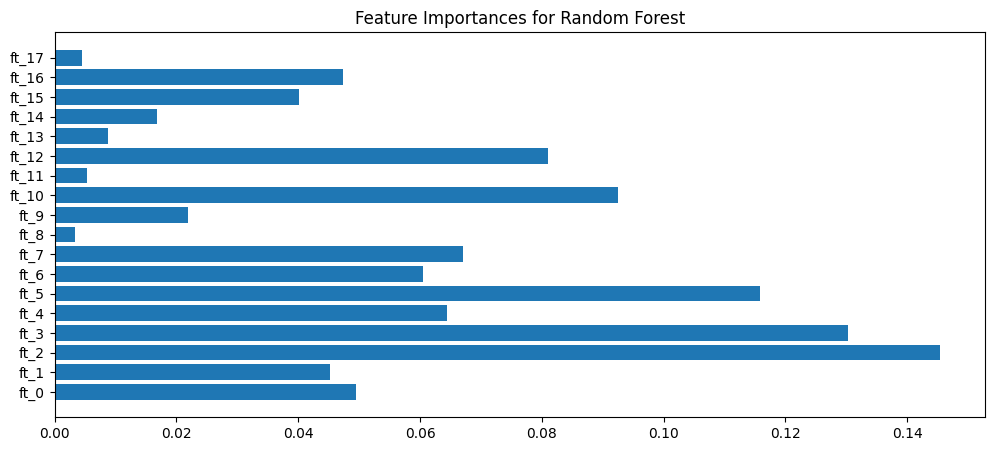

In [173]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf_clf.feature_importances_,
})

plt.figure(figsize=(12, 5))
plt.barh(importances['feature'], importances['importance'])
plt.title('Feature Importances for Random Forest')
plt.show()

Можно попробовать удалить признаки 8, 11 и 17, потому что их также "отсеяли" статистические тесты:

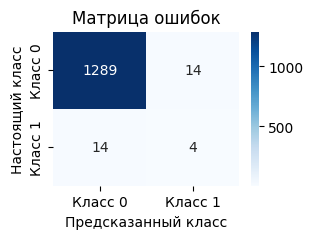

Precision=0.22, recall=0.22, f1-score_macro=0.61, roc_auc=0.61


In [175]:
del_features = ['ft_8', 'ft_11', 'ft_17']

best_rf_clf = fit_rf(X_train.drop(del_features, axis=1), y_train).best_estimator_
y_pred = best_rf_clf.predict(X_test.drop(del_features, axis=1))
display_metrics(y_test, y_pred)

Стало лучше, но не сильно. Попробуем сбалансировать классы синтетическими данными:

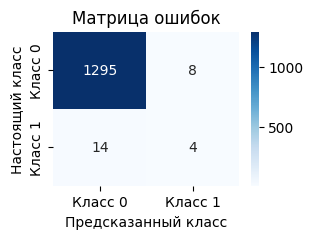

Precision=0.33, recall=0.22, f1-score_macro=0.63, roc_auc=0.61


In [176]:
X_train_bal, y_train_bal = get_syn_data(X_train, y_train)

best_rf_clf = fit_rf(X_train.drop(del_features, axis=1), y_train).best_estimator_
y_pred = best_rf_clf.predict(X_test.drop(del_features, axis=1))
display_metrics(y_test, y_pred)

Посмотрим важность фичей при сбалансированной выборке:

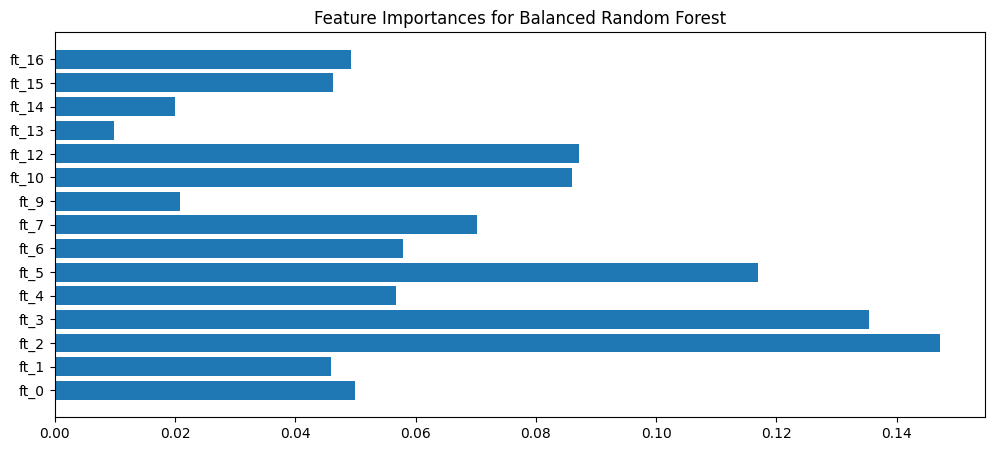

In [178]:
importances = pd.DataFrame({
    'feature': X_train.drop(del_features, axis=1).columns,
    'importance': best_rf_clf.feature_importances_,
})

plt.figure(figsize=(12, 5))
plt.barh(importances['feature'], importances['importance'])
plt.title('Feature Importances for Balanced Random Forest')
plt.show()

В принципе все остальные фичи задействуются при предсказании.

### 4. Заключение

К сожалению, время на тестовое задание ограничено (и мое свободное от основной работы время тоже), поэтому придется остановиться на этом результате. Полученные модели не сильно отличаются по качеству, у каждой есть свой небольшой выигрыш (какая-то выигрывает по точности, какая-то по полноте и т.д.). Необхходимо знать бизнес-задачу, чтобы найти лучший классификатор.

Также я бы попробовал посмотреть, как бы себя показал классификатор на бустинге (XGBoost, CatBoost).
Помимо этого, я бы попробовал "неклассические" подходы. Так как присутствует сильный дисбаланс классов, можно попробовать обучать ансамбль knn-классификаторов (или обычных деревьев) на всех объектах положительного класса и рандомной выборке такого же размера объектов отрицательного класса, а затем агрегировать как-то их предсказания. Возможно, это дало бы неплохой результат.

В целом классы довольно плохо различаются. Есть даже подозрение, что сильно лучшего результата добиться в принципе не возможно на таких данных. Но это только предположение.